
# Post-tuning the decision threshold for cost-sensitive learning

Once a classifier is trained, the output of the :term:`predict` method outputs class
label predictions corresponding to a thresholding of either the
:term:`decision_function` or the :term:`predict_proba` output. For a binary classifier,
the default threshold is defined as a posterior probability estimate of 0.5 or a
decision score of 0.0.

However, this default strategy is most likely not optimal for the task at hand.
Here, we use the "Statlog" German credit dataset [1]_ to illustrate a use case.
In this dataset, the task is to predict whether a person has a "good" or "bad" credit.
In addition, a cost-matrix is provided that specifies the cost of
misclassification. Specifically, misclassifying a "bad" credit as "good" is five
times more costly on average than misclassifying a "good" credit as "bad".

We use the :class:`~sklearn.model_selection.TunedThresholdClassifierCV` to select the
cut-off point of the decision function that minimizes the provided business
cost.

In the second part of the example, we further extend this approach by
considering the problem of fraud detection in credit card transactions: in this
case, the business metric depends on the amount of each individual transaction.

.. rubric :: References

.. [1] "Statlog (German Credit Data) Data Set", UCI Machine Learning Repository,
    [Link](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).

.. [2] [Charles Elkan, "The Foundations of Cost-Sensitive Learning",
    International joint conference on artificial intelligence.
    Vol. 17. No. 1. Lawrence Erlbaum Associates Ltd, 2001.](https://cseweb.ucsd.edu/~elkan/rescale.pdf)


In [40]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Cost-sensitive learning with constant gains and costs

In this first section, we illustrate the use of the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` in a setting of
cost-sensitive learning when the gains and costs associated to each entry of the
confusion matrix are constant. We use the problematic presented in [2]_ using the
"Statlog" German credit dataset [1]_.

### "Statlog" German credit dataset

We fetch the German credit dataset from OpenML.



In [41]:
import sklearn
from sklearn.datasets import fetch_openml

sklearn.set_config(transform_output="pandas")

german_credit = fetch_openml(data_id=31, as_frame=True, parser="pandas")
X, y = german_credit.data, german_credit.target

We check the feature types available in `X`.



In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

Many features are categorical and usually string-encoded. We need to encode
these categories when we develop our predictive model. Let's check the targets.



In [43]:
y.value_counts()

class
good    700
bad     300
Name: count, dtype: int64

Another observation is that the dataset is imbalanced. We would need to be careful
when evaluating our predictive model and use a family of metrics that are adapted
to this setting.

In addition, we observe that the target is string-encoded. Some metrics
(e.g. precision and recall) require to provide the label of interest also called
the "positive label". Here, we define that our goal is to predict whether or not
a sample is a "bad" credit.



In [44]:
pos_label, neg_label = "bad", "good"

To carry our analysis, we split our dataset using a single stratified split.



In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

We are ready to design our predictive model and the associated evaluation strategy.

### Evaluation metrics

In this section, we define a set of metrics that we use later. To see
the effect of tuning the cut-off point, we evaluate the predictive model using
the Receiver Operating Characteristic (ROC) curve and the Precision-Recall curve.
The values reported on these plots are therefore the true positive rate (TPR),
also known as the recall or the sensitivity, and the false positive rate (FPR),
also known as the specificity, for the ROC curve and the precision and recall for
the Precision-Recall curve.

From these four metrics, scikit-learn does not provide a scorer for the FPR. We
therefore need to define a small custom function to compute it.



In [46]:
from sklearn.metrics import confusion_matrix


def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

As previously stated, the "positive label" is not defined as the value "1" and calling
some of the metrics with this non-standard value raise an error. We need to
provide the indication of the "positive label" to the metrics.

We therefore need to define a scikit-learn scorer using
:func:`~sklearn.metrics.make_scorer` where the information is passed. We store all
the custom scorers in a dictionary. To use them, we need to pass the fitted model,
the data and the target on which we want to evaluate the predictive model.



In [47]:
from sklearn.metrics import make_scorer, precision_score, recall_score

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

In addition, the original research [1]_ defines a custom business metric. We
call a "business metric" any metric function that aims at quantifying how the
predictions (correct or wrong) might impact the business value of deploying a
given machine learning model in a specific application context. For our
credit prediction task, the authors provide a custom cost-matrix which
encodes that classifying a a "bad" credit as "good" is 5 times more costly on
average than the opposite: it is less costly for the financing institution to
not grant a credit to a potential customer that will not default (and
therefore miss a good customer that would have otherwise both reimbursed the
credit and payed interests) than to grant a credit to a customer that will
default.

We define a python function that weight the confusion matrix and return the
overall cost.



In [48]:
import numpy as np


def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    # The rows of the confusion matrix hold the counts of observed classes
    # while the columns hold counts of predicted classes. Recall that here we
    # consider "bad" as the positive class (second row and column).
    # Scikit-learn model selection tools expect that we follow a convention
    # that "higher" means "better", hence the following gain matrix assigns
    # negative gains (costs) to the two kinds of prediction errors:
    # - a gain of -1 for each false positive ("good" credit labeled as "bad"),
    # - a gain of -5 for each false negative ("bad" credit labeled as "good"),
    # The true positives and true negatives are assigned null gains in this
    # metric.
    #
    # Note that theoretically, given that our model is calibrated and our data
    # set representative and large enough, we do not need to tune the
    # threshold, but can safely set it to the cost ration 1/5, as stated by Eq.
    # (2) in Elkan paper [2]_.
    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


scoring["credit_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label
)

### Vanilla predictive model

We use :class:`~sklearn.ensemble.HistGradientBoostingClassifier` as a predictive model
that natively handles categorical features and missing values.



In [49]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    categorical_features="from_dtype", random_state=0
).fit(X_train, y_train)
model

HistGradientBoostingClassifier(random_state=0)

We evaluate the performance of our predictive model using the ROC and Precision-Recall
curves.



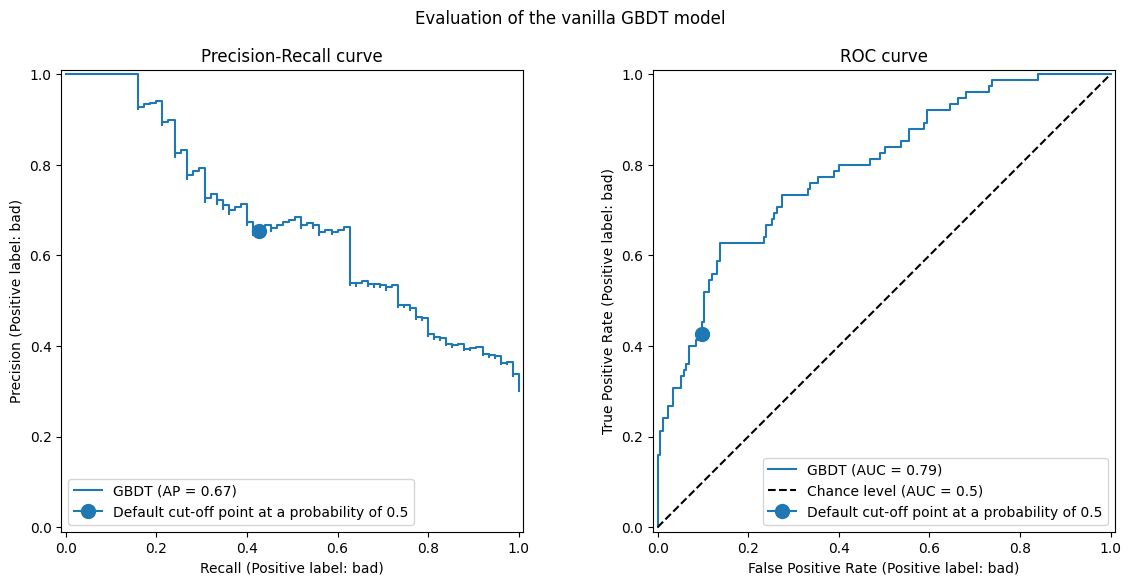

In [50]:
import matplotlib.pyplot as plt

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, pos_label=pos_label, ax=axs[0], name="GBDT"
)
axs[0].plot(
    scoring["recall"](model, X_test, y_test),
    scoring["precision"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=pos_label,
    ax=axs[1],
    name="GBDT",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](model, X_test, y_test),
    scoring["tpr"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the vanilla GBDT model")

We recall that these curves give insights on the statistical performance of the
predictive model for different cut-off points. For the Precision-Recall curve, the
reported metrics are the precision and recall and for the ROC curve, the reported
metrics are the TPR (same as recall) and FPR.

Here, the different cut-off points correspond to different levels of posterior
probability estimates ranging between 0 and 1. By default, `model.predict` uses a
cut-off point at a probability estimate of 0.5. The metrics for such a cut-off point
are reported with the blue dot on the curves: it corresponds to the statistical
performance of the model when using `model.predict`.

However, we recall that the original aim was to minimize the cost (or maximize the
gain) as defined by the business metric. We can compute the value of the business
metric:



In [51]:
print(f"Business defined metric: {scoring['credit_gain'](model, X_test, y_test)}")

Business defined metric: -232


At this stage we don't know if any other cut-off can lead to a greater gain. To find
the optimal one, we need to compute the cost-gain using the business metric for all
possible cut-off points and choose the best. This strategy can be quite tedious to
implement by hand, but the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` class is here to help us.
It automatically computes the cost-gain for all possible cut-off points and optimizes
for the `scoring`.


### Tuning the cut-off point

We use :class:`~sklearn.model_selection.TunedThresholdClassifierCV` to tune the
cut-off point. We need to provide the business metric to optimize as well as the
positive label. Internally, the optimum cut-off point is chosen such that it maximizes
the business metric via cross-validation. By default a 5-fold stratified
cross-validation is used.



In [52]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["credit_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.02


We plot the ROC and Precision-Recall curves for the vanilla model and the tuned model.
Also we plot the cut-off points that would be used by each model. Because, we are
reusing the same code later, we define a function that generates the plots.



In [53]:
def plot_roc_pr_curves(vanilla_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla GBDT", "Tuned GBDT")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

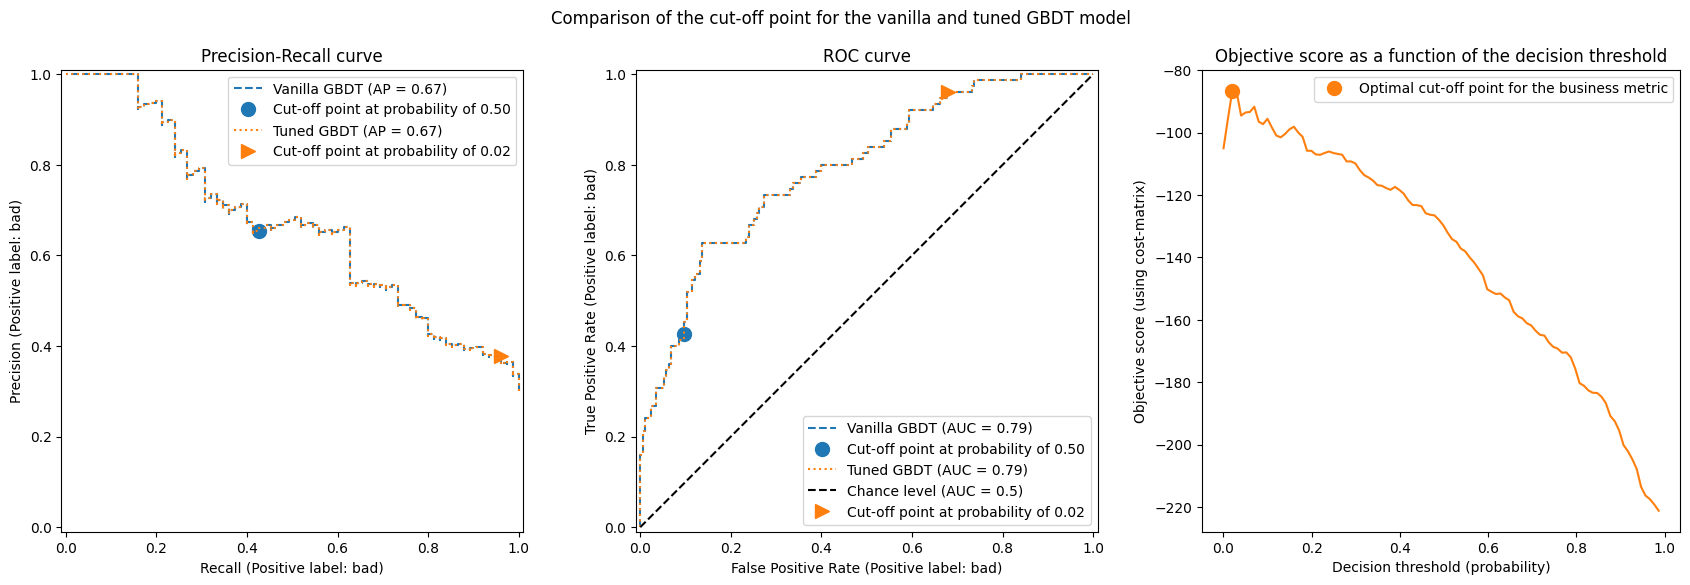

In [54]:
title = "Comparison of the cut-off point for the vanilla and tuned GBDT model"
plot_roc_pr_curves(model, tuned_model, title=title)

The first remark is that both classifiers have exactly the same ROC and
Precision-Recall curves. It is expected because by default, the classifier is fitted
on the same training data. In a later section, we discuss more in detail the
available options regarding model refitting and cross-validation.

The second remark is that the cut-off points of the vanilla and tuned model are
different. To understand why the tuned model has chosen this cut-off point, we can
look at the right-hand side plot that plots the objective score that is our exactly
the same as our business metric. We see that the optimum threshold corresponds to the
maximum of the objective score. This maximum is reached for a decision threshold
much lower than 0.5: the tuned model enjoys a much higher recall at the cost of
of significantly lower precision: the tuned model is much more eager to
predict the "bad" class label to larger fraction of individuals.

We can now check if choosing this cut-off point leads to a better score on the testing
set:



In [55]:
print(f"Business defined metric: {scoring['credit_gain'](tuned_model, X_test, y_test)}")

Business defined metric: -134


We observe that tuning the decision threshold almost improves our business gains
by factor of 2.


### Consideration regarding model refitting and cross-validation

In the above experiment, we used the default setting of the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV`. In particular, the
cut-off point is tuned using a 5-fold stratified cross-validation. Also, the
underlying predictive model is refitted on the entire training data once the cut-off
point is chosen.

These two strategies can be changed by providing the `refit` and `cv` parameters.
For instance, one could provide a fitted `estimator` and set `cv="prefit"`, in which
case the cut-off point is found on the entire dataset provided at fitting time.
Also, the underlying classifier is not be refitted by setting `refit=False`. Here, we
can try to do such experiment.



In [56]:
model.fit(X_train, y_train)
tuned_model.set_params(cv="prefit", refit=False).fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.28


Then, we evaluate our model with the same approach as before:



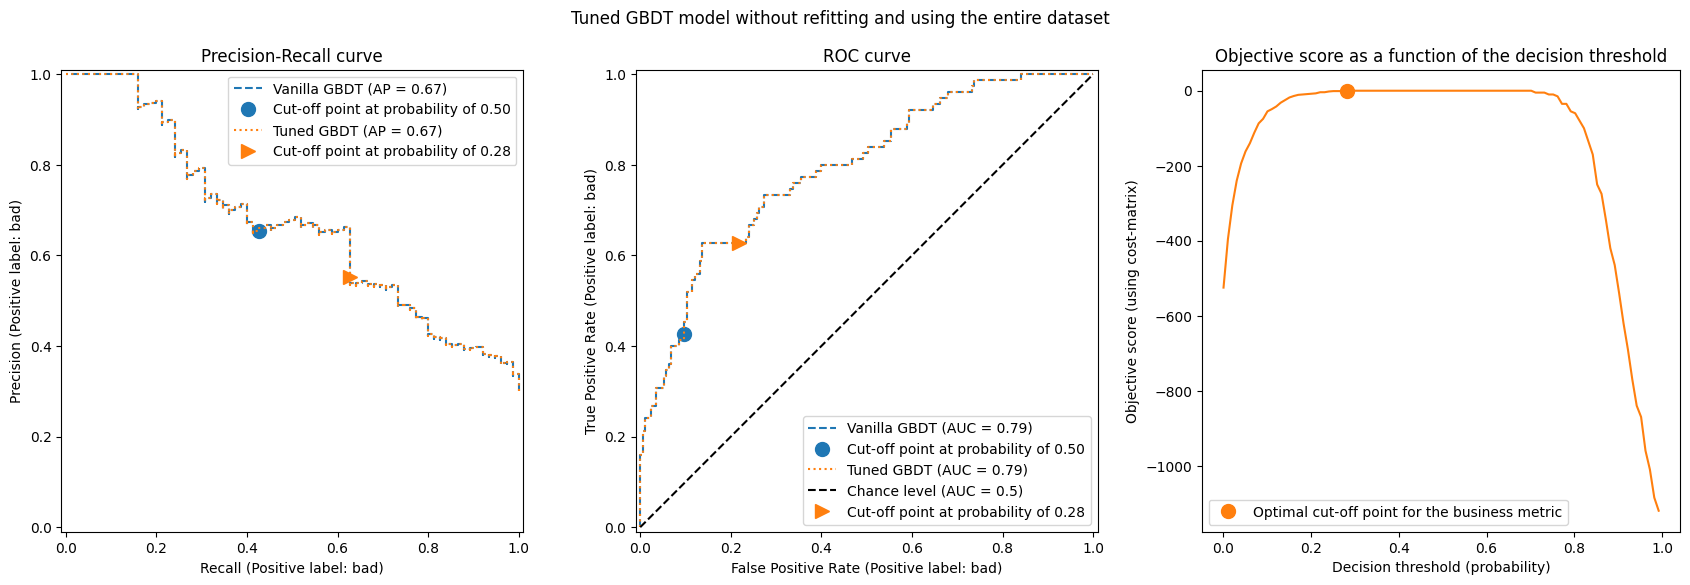

In [57]:
title = "Tuned GBDT model without refitting and using the entire dataset"
plot_roc_pr_curves(model, tuned_model, title=title)

We observe the that the optimum cut-off point is different from the one found
in the previous experiment. If we look at the right-hand side plot, we
observe that the business gain has large plateau of near-optimal 0 gain for a
large span of decision thresholds. This behavior is symptomatic of an
overfitting. Because we disable cross-validation, we tuned the cut-off point
on the same set as the model was trained on, and this is the reason for the
observed overfitting.

This option should therefore be used with caution. One needs to make sure that the
data provided at fitting time to the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` is not the same as the
data used to train the underlying classifier. This could happen sometimes when the
idea is just to tune the predictive model on a completely new validation set without a
costly complete refit.

When cross-validation is too costly, a potential alternative is to use a
single train-test split by providing a floating number in range `[0, 1]` to the `cv`
parameter. It splits the data into a training and testing set. Let's explore this
option:



In [58]:
tuned_model.set_params(cv=0.75).fit(X_train, y_train)

TunedThresholdClassifierCV(cv=0.75,
                           estimator=HistGradientBoostingClassifier(random_state=0),
                           refit=False,
                           scoring=make_scorer(credit_gain_score, response_method='predict', neg_label=good, pos_label=bad),
                           store_cv_results=True)

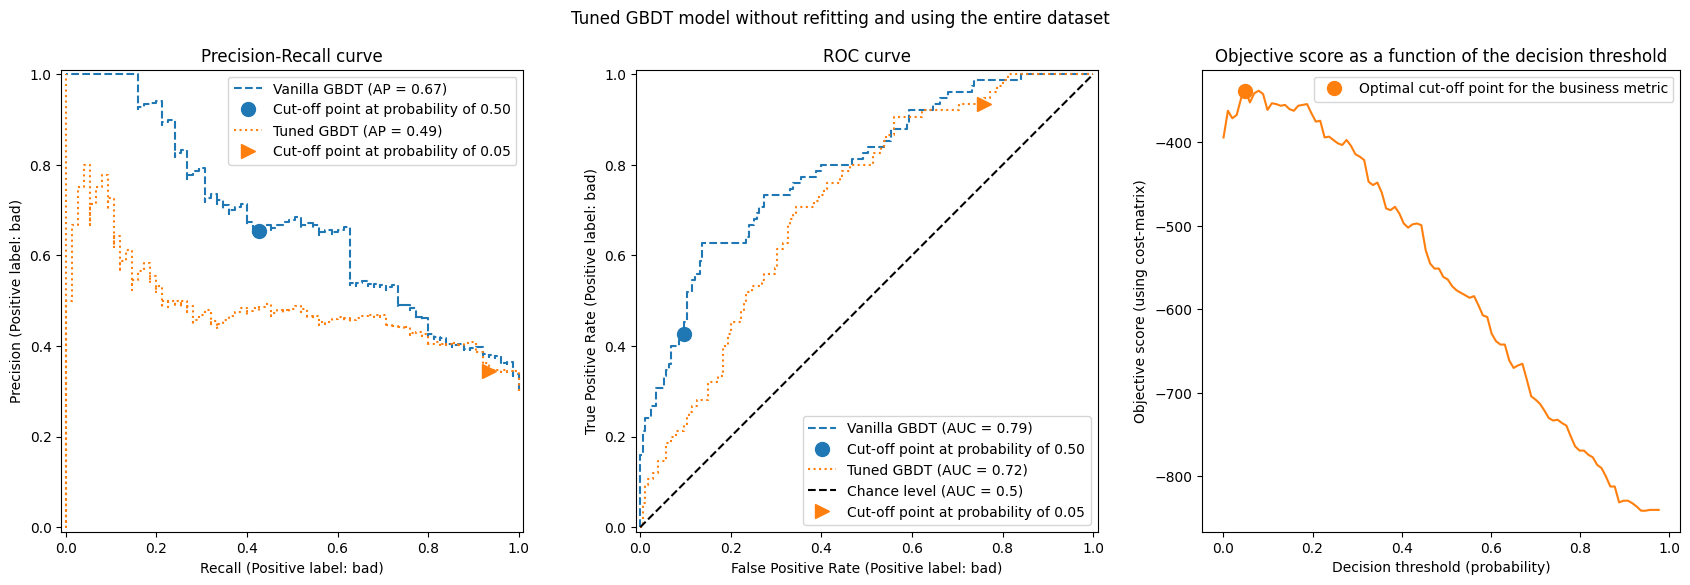

In [59]:
title = "Tuned GBDT model without refitting and using the entire dataset"
plot_roc_pr_curves(model, tuned_model, title=title)

Regarding the cut-off point, we observe that the optimum is similar to the multiple
repeated cross-validation case. However, be aware that a single split does not account
for the variability of the fit/predict process and thus we are unable to know if there
is any variance in the cut-off point. The repeated cross-validation averages out
this effect.

Another observation concerns the ROC and Precision-Recall curves of the tuned model.
As expected, these curves differ from those of the vanilla model, given that we
trained the underlying classifier on a subset of the data provided during fitting and
reserved a validation set for tuning the cut-off point.

## Cost-sensitive learning when gains and costs are not constant

As stated in [2]_, gains and costs are generally not constant in real-world problems.
In this section, we use a similar example as in [2]_ for the problem of
detecting fraud in credit card transaction records.

### The credit card dataset



In [60]:
credit_card = fetch_openml(data_id=1597, as_frame=True, parser="pandas")
credit_card.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   V1      284807 non-null  float64 
 1   V2      284807 non-null  float64 
 2   V3      284807 non-null  float64 
 3   V4      284807 non-null  float64 
 4   V5      284807 non-null  float64 
 5   V6      284807 non-null  float64 
 6   V7      284807 non-null  float64 
 7   V8      284807 non-null  float64 
 8   V9      284807 non-null  float64 
 9   V10     284807 non-null  float64 
 10  V11     284807 non-null  float64 
 11  V12     284807 non-null  float64 
 12  V13     284807 non-null  float64 
 13  V14     284807 non-null  float64 
 14  V15     284807 non-null  float64 
 15  V16     284807 non-null  float64 
 16  V17     284807 non-null  float64 
 17  V18     284807 non-null  float64 
 18  V19     284807 non-null  float64 
 19  V20     284807 non-null  float64 
 20  V21     284807 non-null  f

The dataset contains information about credit card records from which some are
fraudulent and others are legitimate. The goal is therefore to predict whether or
not a credit card record is fraudulent.



In [61]:
columns_to_drop = ["Class"]
data = credit_card.frame.drop(columns=columns_to_drop)
target = credit_card.frame["Class"].astype(int)

First, we check the class distribution of the datasets.



In [62]:
target.value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

The dataset is highly imbalanced with fraudulent transaction representing only 0.17%
of the data. Since we are interested in training a machine learning model, we should
also make sure that we have enough samples in the minority class to train the model.



In [63]:
target.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

We observe that we have around 500 samples that is on the low end of the number of
samples required to train a machine learning model. In addition of the target
distribution, we check the distribution of the amount of the
fraudulent transactions.



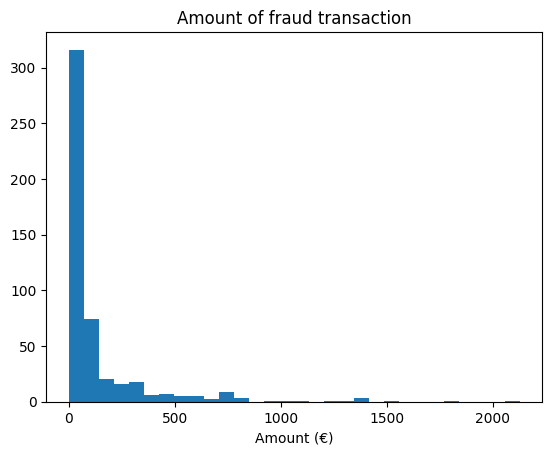

In [64]:
fraud = target == 1
amount_fraud = data["Amount"][fraud]
_, ax = plt.subplots()
ax.hist(amount_fraud, bins=30)
ax.set_title("Amount of fraud transaction")
_ = ax.set_xlabel("Amount (€)")

### Addressing the problem with a business metric

Now, we create the business metric that depends on the amount of each transaction. We
define the cost matrix similarly to [2]_. Accepting a legitimate transaction provides
a gain of 2% of the amount of the transaction. However, accepting a fraudulent
transaction result in a loss of the amount of the transaction. As stated in [2]_, the
gain and loss related to refusals (of fraudulent and legitimate transactions) are not
trivial to define. Here, we define that a refusal of a legitimate transaction
is estimated to a loss of 5€ while the refusal of a fraudulent transaction is
estimated to a gain of 50€. Therefore, we define the following function to
compute the total benefit of a given decision:



In [65]:
def business_metric(y_true, y_pred, amount):
    mask_true_positive = (y_true == 1) & (y_pred == 1)
    mask_true_negative = (y_true == 0) & (y_pred == 0)
    mask_false_positive = (y_true == 0) & (y_pred == 1)
    mask_false_negative = (y_true == 1) & (y_pred == 0)
    fraudulent_refuse = mask_true_positive.sum() * 50
    fraudulent_accept = -amount[mask_false_negative].sum()
    legitimate_refuse = mask_false_positive.sum() * -5
    legitimate_accept = (amount[mask_true_negative] * 0.02).sum()
    return fraudulent_refuse + fraudulent_accept + legitimate_refuse + legitimate_accept

From this business metric, we create a scikit-learn scorer that given a fitted
classifier and a test set compute the business metric. In this regard, we use
the :func:`~sklearn.metrics.make_scorer` factory. The variable `amount` is an
additional metadata to be passed to the scorer and we need to use
`metadata routing <metadata_routing>` to take into account this information.



In [66]:
sklearn.set_config(enable_metadata_routing=True)
business_scorer = make_scorer(business_metric).set_score_request(amount=True)

So at this stage, we observe that the amount of the transaction is used twice: once
as a feature to train our predictive model and once as a metadata to compute the
the business metric and thus the statistical performance of our model. When used as a
feature, we are only required to have a column in `data` that contains the amount of
each transaction. To use this information as metadata, we need to have an external
variable that we can pass to the scorer or the model that internally routes this
metadata to the scorer. So let's create this variable.



In [67]:
amount = credit_card.frame["Amount"].to_numpy()

In [68]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test, amount_train, amount_test = (
    train_test_split(
        data, target, amount, stratify=target, test_size=0.5, random_state=42
    )
)

We first evaluate some baseline policies to serve as reference. Recall that
class "0" is the legitimate class and class "1" is the fraudulent class.



In [69]:
from sklearn.dummy import DummyClassifier

always_accept_policy = DummyClassifier(strategy="constant", constant=0)
always_accept_policy.fit(data_train, target_train)
benefit = business_scorer(
    always_accept_policy, data_test, target_test, amount=amount_test
)
print(f"Benefit of the 'always accept' policy: {benefit:,.2f}€")

Benefit of the 'always accept' policy: 221,445.07€


A policy that considers all transactions as legitimate would create a profit of
around 220,000€. We make the same evaluation for a classifier that predicts all
transactions as fraudulent.



In [70]:
always_reject_policy = DummyClassifier(strategy="constant", constant=1)
always_reject_policy.fit(data_train, target_train)
benefit = business_scorer(
    always_reject_policy, data_test, target_test, amount=amount_test
)
print(f"Benefit of the 'always reject' policy: {benefit:,.2f}€")

Benefit of the 'always reject' policy: -698,490.00€


Such a policy would entail a catastrophic loss: around 670,000€. This is
expected since the vast majority of the transactions are legitimate and the
policy would refuse them at a non-trivial cost.

A predictive model that adapts the accept/reject decisions on a per
transaction basis should ideally allow us to make a profit larger than the
220,000€ of the best of our constant baseline policies.

We start with a logistic regression model with the default decision threshold
at 0.5. Here we tune the hyperparameter `C` of the logistic regression with a
proper scoring rule (the log loss) to ensure that the model's probabilistic
predictions returned by its `predict_proba` method are as accurate as
possible, irrespectively of the choice of the value of the decision
threshold.



In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

logistic_regression = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {"logisticregression__C": np.logspace(-6, 6, 13)}
model = GridSearchCV(logistic_regression, param_grid, scoring="neg_log_loss").fit(
    data_train, target_train
)
model

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])},
             scoring='neg_log_loss')

In [72]:
print(
    "Benefit of logistic regression with default threshold: "
    f"{business_scorer(model, data_test, target_test, amount=amount_test):,.2f}€"
)

Benefit of logistic regression with default threshold: 244,919.87€


The business metric shows that our predictive model with a default decision
threshold is already winning over the baseline in terms of profit and it would be
already beneficial to use it to accept or reject transactions instead of
accepting all transactions.

### Tuning the decision threshold

Now the question is: is our model optimum for the type of decision that we want to do?
Up to now, we did not optimize the decision threshold. We use the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` to optimize the decision
given our business scorer. To avoid a nested cross-validation, we will use the
best estimator found during the previous grid-search.



In [73]:
tuned_model = TunedThresholdClassifierCV(
    estimator=model.best_estimator_,
    scoring=business_scorer,
    thresholds=100,
    n_jobs=2,
)

Since our business scorer requires the amount of each transaction, we need to pass
this information in the `fit` method. The
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` is in charge of
automatically dispatching this metadata to the underlying scorer.



In [74]:
tuned_model.fit(data_train, target_train, amount=amount_train)

TunedThresholdClassifierCV(estimator=Pipeline(steps=[('standardscaler',
                                                      StandardScaler()),
                                                     ('logisticregression',
                                                      LogisticRegression(C=np.float64(100.0)))]),
                           n_jobs=2,
                           scoring=make_scorer(business_metric, response_method='predict'))

We observe that the tuned decision threshold is far away from the default 0.5:



In [75]:
print(f"Tuned decision threshold: {tuned_model.best_threshold_:.2f}")

Tuned decision threshold: 0.03


In [76]:
print(
    "Benefit of logistic regression with a tuned threshold: "
    f"{business_scorer(tuned_model, data_test, target_test, amount=amount_test):,.2f}€"
)

Benefit of logistic regression with a tuned threshold: 249,433.39€


We observe that tuning the decision threshold increases the expected profit
when deploying our model - as indicated by the business metric. It is therefore
valuable, whenever possible, to optimize the decision threshold with respect
to the business metric.

### Manually setting the decision threshold instead of tuning it

In the previous example, we used the
:class:`~sklearn.model_selection.TunedThresholdClassifierCV` to find the optimal
decision threshold. However, in some cases, we might have some prior knowledge about
the problem at hand and we might be happy to set the decision threshold manually.

The class :class:`~sklearn.model_selection.FixedThresholdClassifier` allows us to
manually set the decision threshold. At prediction time, it behave as the previous
tuned model but no search is performed during the fitting process. Note that here
we use :class:`~sklearn.frozen.FrozenEstimator` to wrap the predictive model to
avoid any refitting.

Here, we will reuse the decision threshold found in the previous section to create a
new model and check that it gives the same results.



In [77]:
from sklearn.frozen import FrozenEstimator
from sklearn.model_selection import FixedThresholdClassifier

model_fixed_threshold = FixedThresholdClassifier(
    estimator=FrozenEstimator(model), threshold=tuned_model.best_threshold_
)

In [78]:
business_score = business_scorer(
    model_fixed_threshold, data_test, target_test, amount=amount_test
)
print(f"Benefit of logistic regression with a tuned threshold:  {business_score:,.2f}€")

Benefit of logistic regression with a tuned threshold:  249,433.39€


We observe that we obtained the exact same results but the fitting process
was much faster since we did not perform any hyper-parameter search.

Finally, the estimate of the (average) business metric itself can be unreliable, in
particular when the number of data points in the minority class is very small.
Any business impact estimated by cross-validation of a business metric on
historical data (offline evaluation) should ideally be confirmed by A/B testing
on live data (online evaluation). Note however that A/B testing models is
beyond the scope of the scikit-learn library itself.

